In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

import torchvision.datasets as datasets
from pathlib import Path

from torchview import draw_graph

import constants
import dataset
import util
import json
import pandas as pd
from model import VQANet
import matplotlib.pyplot as plt
import numpy as np


USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():      
    device = 'mps'                         
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)




using device: mps


In [2]:

%load_ext autoreload
%autoreload 2

In [3]:

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [23]:
with open(constants.CAPTION_TRAIN, 'r') as f:
    data = json.load(f)
    print(data.keys())
    print(data["annotations"][0])

with open(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, 'r') as f:
    data = json.load(f)
    print(data.keys())
    print(data["questions"][0])

with open(constants.VQA_OPEN_ENDED_ANSWER_TRAIN, 'r') as f:
    data = json.load(f)
    print(data.keys())
    print(data["annotations"][0])
    
# with open(constants.CAPTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_QUESTION_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

# with open(constants.VQA_OPEN_ENDED_ANSWER_VAL, 'r') as f:
#     data = json.load(f)
#     print(data.keys())

#dataset.load(constants.VQA_OPEN_ENDED_QUESTION_TRAIN, ['image_id', 'id', 'caption'])

dict_keys(['info', 'licenses', 'images', 'annotations'])
{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}
dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
{'image_id': 458752, 'question': 'What is this photo taken looking through?', 'question_id': 458752000}
dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])
{'question_type': 'what is this', 'multiple_choice_answer': 'net', 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7}, {'answer': 'net', 'answer_confidence': 'yes', 'answer

In [3]:
train = dataset.Coco()
val = dataset.Coco("validation")
test = dataset.Coco("test")

Found annotations at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/instances_train2017.json'
Images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Found annotations at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Found test info at '/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/raw/image_info_test2017.json'
Images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'coco-2017-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [48]:
max_caption_len = train.captions["caption"].str.len().min()
max_q_len = train.questions["question"].str.len().min()
max_a_len = train.answers["multiple_choice_answer"].str.len().min()

print(max_caption_len)
print(max_q_len)
print(max_a_len)

21
10
1


In [4]:
print(len(train))
print(len(train.captions))
img = train.__getitem__(1)

118287
591753


9
/Users/xiangyuliu/sources/fiftyone_dataset_zoo/coco-2017/train/data/000000000009.jpg
>>>>
['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']
>>>>
[('How many cookies can be seen?', '2'), ('What color are the dishes?', 'pink and yellow'), ('What is the green stuff?', 'broccoli')]


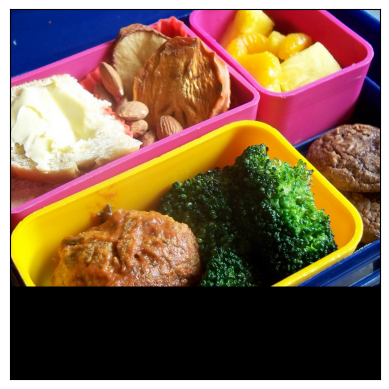

In [30]:
print(img)
print(img.image_id)
print(img.image_path)

print(">>>>")
print(img.captions())

print(">>>>")
print(img.qa())

show([img.image_tensor()])

#plt.imshow(  img.image_tensor().permute(1, 2, 0)  )


In [ ]:
tokenizer  = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Add the Q and A token as special token
tokenizer.add_special_tokens(constants.QA_TOKEN_DICT)

In [6]:
def make_qa(q, a):
    return constants.QUESTION_TOKEN +' ' + q +' ' + constants.ANSWER_TOKEN + ' ' + a + ' ' + constants.END_TOKEN

# flatten the imgae data into (image, caption, qa)
def collate_fn(batch):
    '''
    Padds batch of variable length
    '''
    results = []
    
    for idx, data in enumerate(batch):
        caption_list = data.captions()
        if caption_list is None:
            caption_list = [constants.EMPTY_TOKEN]
        
        qa_list = data.qa()
        if qa_list is None:
            qa_list = [(constants.EMPTY_TOKEN,constants.EMPTY_TOKEN)]
            
        for c in caption_list:
            for (q, a) in qa_list:
                results.append((data.image_id, data.image_tensor(), c, q, a))
    return results


In [7]:
from torch.utils.data import DataLoader
batch_size = 3 #64
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [8]:
x = next(iter(train_dataloader))


In [11]:
def flatten(results):
    ids = []
    images = []
    captions = []
    qs = []
    ans = []
    for (image_id, tensor, c, q, a) in results:
        ids.append(image_id)
        images.append(tensor)
        captions.append(c)
        qs.append(q)
        ans.append(a)
    return ids, torch.stack(images, dim=0), captions, qs, ans

ids, images, captions, qs, ans = flatten(x)
print(images[0])

tensor([[[33, 26, 18,  ...,  0,  0,  0],
         [32, 25, 18,  ...,  0,  0,  0],
         [27, 21, 15,  ...,  0,  0,  0],
         ...,
         [33, 28, 25,  ...,  0,  0,  0],
         [27, 24, 19,  ...,  0,  0,  0],
         [28, 24, 21,  ...,  0,  0,  0]],

        [[32, 25, 18,  ...,  0,  0,  0],
         [31, 24, 18,  ...,  0,  0,  0],
         [27, 21, 15,  ...,  0,  0,  0],
         ...,
         [23, 19, 16,  ...,  0,  0,  0],
         [17, 14, 13,  ...,  0,  0,  0],
         [16, 14, 15,  ...,  0,  0,  0]],

        [[37, 30, 20,  ...,  0,  0,  0],
         [36, 29, 20,  ...,  0,  0,  0],
         [29, 23, 17,  ...,  0,  0,  0],
         ...,
         [24, 20, 17,  ...,  0,  0,  0],
         [18, 15, 13,  ...,  0,  0,  0],
         [18, 15, 15,  ...,  0,  0,  0]]], dtype=torch.uint8)


In [13]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT).eval()


In [19]:
print(images.shape)


weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

new_images = transforms(images)
print(new_images.shape)

torch.Size([35, 3, 640, 640])
torch.Size([35, 3, 640, 640])


In [21]:
print(new_images)

tensor([[[[0.1294, 0.1020, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
          [0.1255, 0.0980, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
          [0.1059, 0.0824, 0.0588,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1294, 0.1098, 0.0980,  ..., 0.0000, 0.0000, 0.0000],
          [0.1059, 0.0941, 0.0745,  ..., 0.0000, 0.0000, 0.0000],
          [0.1098, 0.0941, 0.0824,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1255, 0.0980, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
          [0.1216, 0.0941, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
          [0.1059, 0.0824, 0.0588,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0902, 0.0745, 0.0627,  ..., 0.0000, 0.0000, 0.0000],
          [0.0667, 0.0549, 0.0510,  ..., 0.0000, 0.0000, 0.0000],
          [0.0627, 0.0549, 0.0588,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1451, 0.1176, 0.0784,  ..., 0.0000, 0.0000, 0.0000],
          [0.1412, 0.1137, 0.0784,  ..., 0.0000, 0.0000, 0.0000],
          [0.1137, 0.0902, 0.0667,  ..., 0

In [20]:
model(new_images)

[{'boxes': tensor([[ 48.0311, 187.1034, 308.9712, 377.6711],
          [ 76.0691, 458.2836, 320.5247, 633.2075],
          [183.6536,  75.3598, 423.8282, 238.5607],
          [379.0081,  21.1395, 425.9705,  93.4190],
          [ 37.8349,  92.0205, 422.7214, 585.5222],
          [  5.5155, 167.8406, 429.4906, 540.3696],
          [  0.0000,  64.7769, 431.5508, 595.1534],
          [ 13.8651, 146.6505, 429.1306, 601.5229],
          [193.2271,  73.0952, 432.0408, 421.5607],
          [356.2206,  26.9914, 426.3069, 113.0897],
          [ 39.7416, 180.6673, 371.3905, 576.6462],
          [204.0107,  75.3660, 427.4116, 249.3671],
          [289.5676,  56.4364, 421.6229, 116.3942],
          [ 44.0607, 457.4895, 330.2343, 633.3803],
          [ 91.0202, 464.3252, 215.7437, 630.4363],
          [  0.0000, 376.8960, 410.3434, 630.8959],
          [154.2832, 514.9868, 322.4107, 637.7370],
          [ 74.6829, 114.8208, 409.2883, 357.1738],
          [336.0610,  64.3841, 425.1003, 110.1726],
   

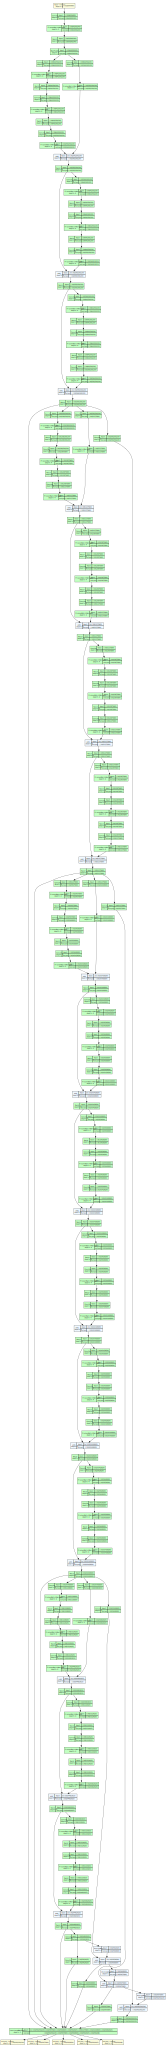

In [10]:


batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model.backbone, input_size=(10, 3, 600, 480), device='mps', depth= 10)
model_graph.visual_graph

In [31]:
for k,v in backbone_out.items():
    print(k, v.shape)

0 torch.Size([10, 256, 256, 200])
1 torch.Size([10, 256, 128, 100])
2 torch.Size([10, 256, 64, 50])
3 torch.Size([10, 256, 32, 25])
pool torch.Size([10, 256, 16, 13])


In [75]:
model = VQANet()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [100]:
print(img.image.shape)
images = img.image.unsqueeze(0)
print(images.shape)
ran = torch.rand((1, 3, 640, 640))
print(ran.shape)
out = model.image_backbone(ran.to(torch.float32))


torch.Size([3, 480, 640])
torch.Size([1, 3, 480, 640])
torch.Size([1, 3, 640, 640])


In [101]:
print(out.keys())

odict_keys(['0', '1', '2', '3', 'pool'])


In [102]:
for k, v in out.items():
    print(k, ":", v.shape)


0 : torch.Size([1, 256, 200, 200])
1 : torch.Size([1, 256, 100, 100])
2 : torch.Size([1, 256, 50, 50])
3 : torch.Size([1, 256, 25, 25])
pool : torch.Size([1, 256, 13, 13])


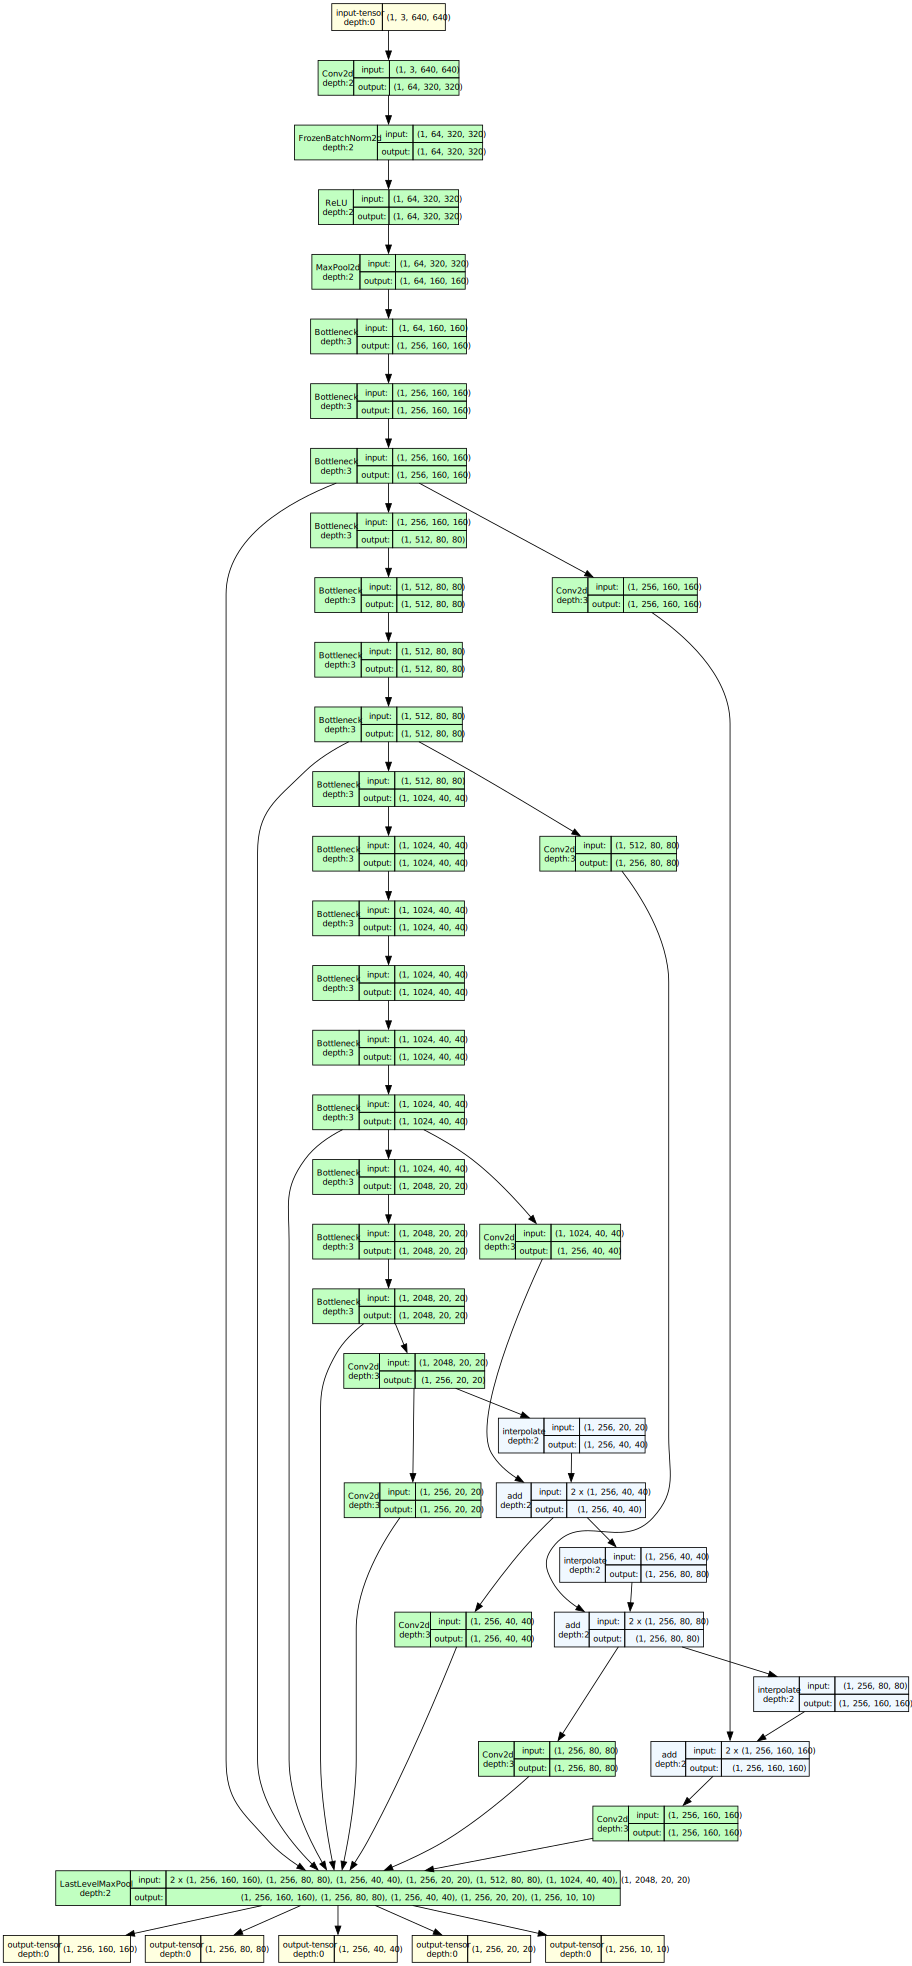

In [103]:
from torchview import draw_graph
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

model_graph = draw_graph(
    model.image_backbone.image_backbone, input_size=(1, 3, 640, 640),
)
model_graph.visual_graph


In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# # List available zoo datasets
print(foz.list_zoo_datasets())

# #
# # Load the COCO-2017 validation split into a FiftyOne dataset
# #
# # This will download the dataset from the web, if necessary
# #
dataset = foz.load_zoo_dataset("coco-2017",    split="validation")

# # Give the dataset a new name, and make it persistent so that you can
# # work with it in future sessions
dataset.name = "coco-2017"
dataset.persistent = True

# # Visualize the in the App
session = fo.launch_app(dataset)

In [ ]:


session = fo.launch_app(dataset)

In [ ]:

import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
  "coco-2014", 
  split="validation",
  label_types=["detections", "caption"],
  max_samples=250,
)
session = fo.launch_app(dataset)

In [ ]:
print("foo")
print(dataset)

In [1]:
from transformers import BertConfig, BertModel

In [71]:
from transformers import AutoTokenizer, BertModel
import torch

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

print(tokenizer)
inputs = tokenizer(["Two men talking on the street",
                    "Foo"], padding=True , return_tensors="pt")
outputs = model(**inputs)



/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertTokenizerFast(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [32]:
print(tokenizer.special_tokens_map)
print(tokenizer(['[UNK] hello world']))
print(tokenizer(['[SEP] hello world']))
print(tokenizer(['[PAD] hello world']))
print(tokenizer(['[CLS] hello world']))


{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[QUESTION]', '[ANSWER]', '[END]']}
{'input_ids': [[101, 100, 7592, 2088, 102]], 'token_type_ids': [[0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1]]}
{'input_ids': [[101, 102, 7592, 2088, 102]], 'token_type_ids': [[0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1]]}
{'input_ids': [[101, 0, 7592, 2088, 102]], 'token_type_ids': [[0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1]]}
{'input_ids': [[101, 101, 7592, 2088, 102]], 'token_type_ids': [[0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1]]}


In [74]:
result = tokenizer(['A giraffe eating food from the top of the tree.', 'A giraffe standing up nearby a tree ', 'A giraffe mother with its baby in the forest.', 'Two giraffes standing in a tree filled area.', 'A giraffe standing next to a forest filled with trees.'])

for ids in result['input_ids']:
    print(len(ids))

print(result)

15
11
14
14
15
{'input_ids': [[101, 1037, 21025, 27528, 7959, 5983, 2833, 2013, 1996, 2327, 1997, 1996, 3392, 1012, 102], [101, 1037, 21025, 27528, 7959, 3061, 2039, 3518, 1037, 3392, 102], [101, 1037, 21025, 27528, 7959, 2388, 2007, 2049, 3336, 1999, 1996, 3224, 1012, 102], [101, 2048, 21025, 27528, 7959, 2015, 3061, 1999, 1037, 3392, 3561, 2181, 1012, 102], [101, 1037, 21025, 27528, 7959, 3061, 2279, 2000, 1037, 3224, 3561, 2007, 3628, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [33]:
print(tokenizer(['[QUESTION] how many ducks? [ANSWER] 2 [END]']))


{'input_ids': [[101, 30522, 2129, 2116, 14875, 1029, 30523, 1016, 30524, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [25]:
print(model.config.hidden_size)
print(outputs.last_hidden_state.shape)
print(tokenizer.special_tokens_map)
print(constants.QA_TOKEN_DICT)

num_added_toks = tokenizer.add_special_tokens(constants.QA_TOKEN_DICT)

print(constants.QA_TOKEN_DICT)
print("We have added", num_added_toks, "tokens")
# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.
model.resize_token_embeddings(len(tokenizer))

768
torch.Size([2, 8, 768])
{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
{'additional_special_tokens': ['[QUESTION]', '[ANSWER]', '[END]']}
{'additional_special_tokens': ['[QUESTION]', '[ANSWER]', '[END]']}
We have added 3 tokens


Embedding(30525, 768)

In [43]:
print(inputs)


{'input_ids': tensor([[ 101, 2048, 2273, 3331, 2006, 1996, 2395,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [9]:
print(outputs.last_hidden_state.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 8, 768])
torch.Size([1, 768])


In [20]:
inputs = tokenizer("this is a super super long super long super long super long super long super long super long super long super long super long super long super long super long super long super long hotdog", return_tensors="pt")
_, output = model(**inputs)
print(outputs.last_hidden_state.shape)
print(outputs.pooler_output.shape)

torch.Size([1, 38, 768])
torch.Size([1, 768])
